# AI演習 第8回
### ディープラーニングによる自然言語処理と時系列データ処理 (3) 

[実行環境]
Colaboratoryの実行環境は更新されるので確認しておきます。

Python: 3.7.15<br>
TensorFlow: 2.9.2<br>
Keras: 2.9.0

ランタイムのタイプは、GPUを指定するように注意してください。

In [ ]:
import tensorflow as tf

print(tf.__version__)
print(tf.keras.__version__)

2.9.2
2.9.0


# ニューラル機械翻訳

* ニューラルネットワークを用いて実現する翻訳機能
* 2014年にRNNを利用した系列変換モデル(sequence-to-sequence model)が考案され、実用化された。
* 2017年にTransformerが考案され、機械翻訳の性能向上に貢献している。



# RNNを利用した系列変換モデルによる機械翻訳

* 翻訳の対象となる文章を系列データとして入力し、翻訳結果の文章を系列データとして出力する。

<img src='https://drive.google.com/uc?export=view&id=1U4jwaSgp2akrDfTv3aKvNQ4DPXLXK2GE' width='70%'>

* 系列変換モデルは、(1)入力となる系列データをエンコードし、(2)エンコードした結果をデコードして系列データを出力するため、エンコード・デコードモデルと呼ばれることがある。
* エンコードした結果を、意味ベクトルと呼ぶ。
* 意味ベクトルは固定長であるため、入力系列データの長さが大きくなると、学習が困難となる。

<img src='https://drive.google.com/uc?export=view&id=1ssHPPADGjdM7xcsvJF5dFy6yuI6iQVEo' width='70%'>

# Attention (注視機構)
* Bahdanau, Cho, Bengioらが、ニューラル機械翻訳に導入(2014年)
* 入力データに対して着目したい特徴に注視(attention)して強調する仕組み



## Self-attention

* 系列データ内で着目したい情報を強調するように、元の系列データを調整する

In [ ]:
!wget http://mattmahoney.net/dc/text8.zip
!unzip text8.zip

In [ ]:
from gensim.models.word2vec import Word2Vec, Text8Corpus
 
sentences = Text8Corpus('text8')
model = Word2Vec(sentences, size=100)

model.save('model.bin')

In [ ]:
model = Word2Vec.load('model.bin')

In [ ]:
text = "I book a room at the hotel."

In [ ]:
text = text.lower() # 小文字にする
text = text.replace('.', ' .') # ピリオドを分割
words = text.split(' ') # 空白を区切りにして単語を分割

In [ ]:
import numpy as np

# Self-attentionの重み行列の作成
a = np.array([])
for w1 in words:
  for w2 in words:
    try:
      score = model.wv.similarity(w1, w2)
    except:
      score = 0

    #print(w1, w2, score)
    a = np.append(a, score)

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

length = len(words)

attention_matrix = a.reshape(length, length)
#feature_names = ["0", "1", "2", "3"]
feature_names = words
# Self-attentionの重みのヒートマップを描く
sns.heatmap(attention_matrix, annot=True,
            xticklabels=feature_names,
            yticklabels=feature_names)

# グラフを表示する
plt.show()

## Self-attentionによるベクトル生成の例

Self-attentionの重みを利用して、"book"の単語ベクトルを調整する。

In [ ]:
attention_weight = attention_matrix[1] # bookのself-attentionの重み
print(attention_weight)

[0.13122362 1.         0.05116783 0.18556051 0.054107   0.01275886
 0.39316773 0.        ]


In [ ]:
book_attention_vec = np.zeros(model.wv["book"].size)

for i, t in enumerate(words):
  try:
    book_attention_vec += attention_weight[i] * model.wv[t]
  except:
    book_attention_vec = book_attention_vec

print ("元のbookベクトル:", model.wv["book"])
print ("Self-attention後のbookベクトル", book_attention_vec)

### 確認例題 3-1
(1)次の英文について、self-attentionの重みのヒートマップを描画してください。

I cut orages with a knife.

(2)さらに、"cut"の単語ベクトルについて、self-attentionによる重みを用いて調整した単語ベクトルを生成してください。



# RNN機械翻訳におけるattention

* 入力系列データの各セルの出力を結合したものを意味ベクトル列とする。
* デコーダのセルの入力に対して、意味ベクトルのどの部分に着目（注視）しているかを考慮して、コンテキストベクトルを生成する。
* 入力系列データが長くなっても、精度が良い。

<img src='https://drive.google.com/uc?export=view&id=1U4zc0A0bt3-7po1QS4aa5Eum5nvUfqOa' width='70%'>

## コンテキストベクトルの計算方法

* デコーダのセルiの出力h'iに対して、意味ベクトル列の各意味ベクトル[h1, h2, …, hn]との内積を計算 → [a1, a2, …, an]
*[a1, a2, …, an]を合計が1となるように正規化 (softmaxを計算) → [a’1, a’2, …, a’n]
*意味ベクトル列の各意味ベクトルの重み付き和を計算 → コンテキストベクトルci


<img src='https://drive.google.com/uc?export=view&id=1ibCk1eq0k8LVp_Bx_Z0GEGHn2MSM-Alx' width='70%'>

## Attentionを用いたRNN系列変換モデルの構成

<img src='https://drive.google.com/uc?export=view&id=1SCu2_Ni9A4OK1E7UYW8BKx2tew0C2Igi' width='70%'>

# Transformer

* Vaswaniらが、2017年に提案
* 機械翻訳モデルとして提案されたが、広く自然言語処理や画像処理にも利用されている
* 英-独翻訳で28.4のBLEUスコア
 * BLEUスコア: 機械翻訳の精度を評価するためのスコア
* RNNのような系列構造を持たず、並列計算による高速化が可能
* BERTやGPT-nなどの深層学習モデルもとになっている
* 画像処理への適用例としては、Vision Transformer (ViT)がある。


## Transformerの構成

<img src='https://drive.google.com/uc?export=view&id=1UoTp8e9Y1NCCsr7-m7QlvQBwWRCFgfNt' width='50%'>

* Multi-head attention: query, key, valueを入力としたアテンション機構。入力データを分割して、複数の構成にしたものをMulti-headと呼んでいる。
* Masked multi-head attention: 後続の単語を参照しないようにするアテンション機構
* Positional encoding: 単語の出現位置についての埋め込み情報 (Vaswaniらは、sin関数、cos関数を用いた計算方法を提案)

## Scaled Dot-Product Attention

* Query、Key、ValueによるAttention機構
* ベクトルの大きさで正規化される（scaledされる）
* Positional Encodeingを用いて、単語の位置情報を加算する

<img src='https://drive.google.com/uc?export=view&id=1w1Wqzmli6PkzPBXR3tpc02pT5WF3LpxZ' width='50%'>

## Multi-head attention

* 入力データを分割して、複数のscaled dot-product attentionで並列処理
* 出力は、各attentionの出力(ベクトル形式)を横方向に連結(concat)

<img src='https://drive.google.com/uc?export=view&id=1cpMJTclA31kwMsLZN_Jv19cvXjp8ETEN' width='30%'>




## Transformerエンコーダによる文章分類

Transformerエンコーダを用いて、IMDBデータセットの映画レビュー文章を分類する。

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [ ]:
vocab_size = 20000 # 単語数
embed_dim = 256 # 単語埋め込み層の次元
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

In [ ]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [ ]:
for item in int_train_ds:
  print(item)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=3, callbacks=callbacks)
model = keras.models.load_model(
    "transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

#### 3-2 確認例題
* Epoch数を増やして分類精度が向上するか確認しましょう。
* さらに、2-1 確認例題で確認した一次元CNN、SimpleRNN、LSTM、GRUに加えて、TransformerEncoderを含めた5つのモデルについて、分類精度を比較し、考察してみましょう。また、各モデルのパラメータ数についても比較してみましょう。

# BERT (Bidirectional Encoder Representations from Transformers)

* 双方向のエンコード表現学習を実現する深層ニューラルネットワーク

* 文脈理解の向上
 * 2019 brazil traveler to usa need a visa <br>
   ブラジルへのアメリカ人旅行者 x <br>
   アメリカへのブラジル人旅行者 o <br>

* 他のモデルへの転移学習が容易
 * 転移学習: 学習済のNNモデルを，他のNNモデルに埋め込んで利用する学習方法．少ない学習データで，認識精度の高いNNモデルが実現できる．
* ラベルが付与されていないデータセットからも学習可能（教師なし学習）

* Transformer: Attentionを用いて時系列データを処理する深層学習モデル
* Attention: 出力シーケンスの生成時に入力シーケンスのどこに注視（attention）するかを判断する仕組み

<br>
<img src='https://drive.google.com/uc?export=view&id=1J-JGdA0-yJsEbfF35goLmJSsKPCUUS-E' width='100%'>

### BERTの事前学習
* BERTは事前学習により構築したモデルを、さらに転移学習（ファインチューニング）することで様々自然言語処理タスクに適用することができる。
* 事前学習は、単語のマスクによる単語推定学習と2つの文章に対する隣接推定学習により実施される。

[例]
初期の学習による推定:<br>
{'input_text': 'i have watched this [mask] and it was awesome',<br>
 'predicted mask token': 'this',<br>
 'prediction': 'i have watched this this and it was awesome',<br>
 'probability': 0.086307295}


中盤の学習による推定:<br>
{'input_text': 'i have watched this [mask] and it was awesome',<br>
 'predicted mask token': 'movie',<br>
 'prediction': 'i have watched this movie and it was awesome',<br>
 'probability': 0.4759983}

### BERTによる文書ベクトルの出力例
* BERTを用いて、単語の分散表現を抽出することができます。文書を単語の集合とみなすと、文書の分散表現も得ることができます。
* ここでは、文書の分散表現を文書ベクトルと呼ぶことにします。
* 文書ベクトル間の類似度を計算することで、似ている文書同士を分類したり、単語ベクトルと文書ベクトルの類似度の計算による文書検索が実現できるようになります。（第6回講義のベクトル空間モデルも参照して下さい。）


<br>
<img src='https://drive.google.com/uc?export=view&id=1HgE6BVMiPAks6J88iYPtcnIk4Uk5kJ5a' width='70%'>

### BERT日本語事前学習モデルの利用
上記の文書ベクトルの出力例をコードで動かしてみます。
BERT日本語事前学習モデルを利用しています。

ここでは、BERT日本語事前学習モデルとして、京都大学で構築した 「Japanese_L-12_H-768_A-12_E-30_BPE_WWM_transformers」を利用します。
このモデルは、入力テキストを形態素解析し、形態素をsubwordに分割したものを基本単位とし、日本語テキストのみ(Wikipediaを利用)で事前学習ししています。

[京都大学のウェブサイト]<br>
http://nlp.ist.i.kyoto-u.ac.jp/index.php?BERT%E6%97%A5%E6%9C%AC%E8%AA%9EPretrained%E3%83%A2%E3%83%87%E3%83%AB

#### Jumanの導入
Juman等、京都大学で開発されたライブラリをインストールします。

Juman: 形態素解析を行うライブラリ<br>
KNP: 日本語文の構文・格・照応解析を行うライブラリ<br>
pyknp: JUMANとKNPをつなぐライブラリ<br>

In [ ]:
!pip install pyknp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wget https://github.com/ku-nlp/jumanpp/releases/download/v2.0.0-rc3/jumanpp-2.0.0-rc3.tar.xz
!sudo apt install cmake
!tar xJvf jumanpp-2.0.0-rc3.tar.xz

In [ ]:
!mkdir ./jumanpp-2.0.0-rc3/bld
!cd ./jumanpp-2.0.0-rc3/bld; cmake ..; sudo make install

#### BERT事前学習モデルなどの準備
京都大学のウェブサイトからファイルをダウンロードします。

In [ ]:
!wget -O Japanese_L-12_H-768_A-12_E-30_BPE_WWM_transformers.zip http://nlp.ist.i.kyoto-u.ac.jp/DLcounter/lime.cgi?down=http://nlp.ist.i.kyoto-u.ac.jp/nl-resource/JapaneseBertPretrainedModel/Japanese_L-12_H-768_A-12_E-30_BPE_WWM_transformers.zip&name=Japanese_L-12_H-768_A-12_E-30_BPE_WWM_transformers.zip 
!unzip Japanese_L-12_H-768_A-12_E-30_BPE_WWM_transformers.zip

In [ ]:
#!pip install transformers==2.5.1
!pip install transformers==3.4.0
#!pip install transformers

In [ ]:
!ls

aclImdb
aclImdb_v1.tar.gz
Japanese_L-12_H-768_A-12_E-30_BPE_WWM_transformers
Japanese_L-12_H-768_A-12_E-30_BPE_WWM_transformers.zip
jumanpp-2.0.0-rc3
jumanpp-2.0.0-rc3.tar.xz
jumanpp-2.0.0-rc3.tar.xz.1
model.bin
sample_data
text8
text8.zip
transformer_encoder.keras


#### BERT事前モデルの読み込み

In [ ]:
# -*- coding: utf-8 -*-
import torch
from pyknp import Juman
from transformers import BertTokenizer, BertModel

text = "今日の授業は大変役に立った。"
bert_model_path = "./Japanese_L-12_H-768_A-12_E-30_BPE_WWM_transformers"

# BERT pre_trained model load
bert_model = BertModel.from_pretrained(bert_model_path)

# for Tokenizer
vocab_file_path = bert_model_path + "/vocab.txt"
bert_tokenizer = BertTokenizer(vocab_file_path, do_lower_case=False, do_basic_tokenize=False)

#### 文書ベクトルの抽出
文章をJumanで品詞分解し、トークンIDの列を取得します。トークンIDの列をBERTに入力し、文書ベクトルを抽出します。

In [ ]:
juman = Juman()
result = juman.analysis(text)
tokens = [mrph.midasi for mrph in result.mrph_list()]
print("JUMAN tokens: ", tokens)

JUMAN tokens:  ['今日', 'の', '授業', 'は', '大変', '役', 'に', '立った', '。']


In [ ]:
bert_tokens = bert_tokenizer.tokenize(" ".join(["[CLS]"] + tokens + ["[SEP]"]))
print("BERT tokens: ", bert_tokens)

token_ids = bert_tokenizer.convert_tokens_to_ids(bert_tokens)
print("BERT token IDs: ", token_ids)

print("\n")
print("[Document vector]")
tokens_tensor = torch.tensor(token_ids).unsqueeze(0)
outputs,_ = bert_model(tokens_tensor)
print(outputs[0])
print("\n (size: ", outputs[0].size(), ")")

BERT tokens:  ['[CLS]', '今日', 'の', '授業', 'は', '大変', '役', 'に', '立った', '。', '[SEP]']
BERT token IDs:  [2, 2281, 5, 4728, 9, 8116, 352, 8, 7894, 7, 3]


[Document vector]
tensor([[ 1.1900, -0.4614, -0.2400,  ...,  0.4808,  0.5996, -0.3095],
        [-0.2990, -0.4036,  0.1444,  ..., -0.3426, -0.0406, -0.0778],
        [-0.4311,  0.1442, -0.6416,  ...,  0.8710,  0.5044, -0.3810],
        ...,
        [ 0.0531,  0.4762,  0.9298,  ...,  0.5106, -0.0382,  0.3643],
        [ 0.4351, -0.3449,  0.1678,  ...,  0.5556,  0.5860,  0.4861],
        [ 0.3368, -0.2108,  0.2384,  ...,  0.4516,  0.9999,  0.4485]],
       grad_fn=<SelectBackward0>)

 (size:  torch.Size([11, 768]) )


#### 確認例題 3-3

3個の文章を用意し、文書ベクトルを生成してみましょう。




#### 確認例題 3-4
さらに、各文章間の類似度をベクトル空間モデルを適用して計算してみましょう。（やり方は確認例題1-2を参考にして下さい。）

# 時系列データと深層学習
* ある現象の時間的な変化を観測して得られる値を対象として、観測時刻と観測値を対応付けたデータ列を時系列データと呼びます。
* 例えば、天気などの気象データ、株価などの金融データ、人や物体などの動作データなどがあります。
* 時系列データを対象とした深層学習には、RNNやLSTMのような，過去の情報を遡って学習できる深層学習モデルを利用します。


## LSTMによる気象予測
* Kerasの公式サイトで公開されているコードを用いて、LSTMによる天気予測を事項してみます。
* 気象データの学習には、ドイツのマックス・プランク研究所で観測されたデータを用いています。

https://www.bgc-jena.mpg.de/wetter/

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

### データの準備と確認

In [ ]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

13568290/13568290 [==============================] - 2s 0us/step


In [ ]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

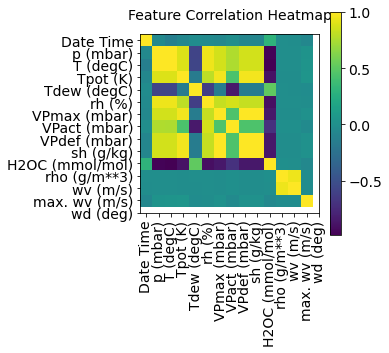

In [ ]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

In [ ]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [ ]:
print(
    "The selected parameters are:",
#    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
    ", ".join([titles[i] for i in [0, 1, 5]]),
)
# selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
selected_features = [feature_keys[i] for i in [0, 1, 5]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure


In [ ]:
start = past + future
end = start + train_split

#x_train = train_data[[i for i in range(7)]].values
x_train = train_data[[i for i in range(3)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

In [ ]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [ ]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

# x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
x_val = val_data.iloc[:x_end][[i for i in range(3)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 3)
Target shape: (256, 1)


In [ ]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=2,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

### 確認例題3-5
* 上記のコードでは、3つの属性"Pressure", "Temperature", "Saturation vapor pressure"を用いて、予測を行うモデルを構築しています。さらに、"Vapor pressure deficit"や"Specific humidity"などの他の属性を加えて予測を行うと、予測精度がどのように変化するかを確認してみましょう。
* 属性のリスト:
 "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",

* なお、epoch数は10程度にしてみましょう。

## LSTMによる人間活動の判定モデル
* 加速度センサーやジャイロセンサーから得られる人間行動データを学習し、活動の種類を判定するLSTMモデルを構築します。
* 学習データには、カルフォルニア大学アーバイン校で公開されているUCI HARデータセットを用います。
https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

In [ ]:
# lstm model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot

#### データの準備

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip "UCI HAR Dataset.zip"

In [ ]:
# load a list of files and return as a 3d numpy array
def load_files(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = read_csv(prefix + name, header=None, delim_whitespace=True)
		loaded.append(data.values)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_files(filenames, filepath)
	# load class output
	y = read_csv(prefix + group + '/y_'+group+'.txt', header=None, delim_whitespace=True)
	return X, y

In [ ]:
	trainX, trainy = load_dataset('train', 'UCI HAR Dataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset('test', 'UCI HAR Dataset/')
	print(testX.shape, testy.shape)
	
	trainy = trainy - 1
	testy = testy - 1
	# one-hotベクトル
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)

#### LSTMモデルの構築

In [ ]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


#### 学習と評価

In [ ]:
model.fit(trainX, trainy, epochs=15, batch_size=64, verbose=0)
_, accuracy = model.evaluate(testX, testy, batch_size=64, verbose=0)

print(accuracy)

0.9009161591529846


#### 確認例題3-6
エポック数を5, 10, 15, 20, 25, 30のように変化させ、認識精度がどのように変化するかを確認してみましょう。

# レポート課題

1. **課題提出用にcolaboratory上で実行するためのページを作成**し、下記の確認例題について実行結果を掲載してください。(**説明文や図など、指定した課題に関係ない内容は削除**してください。)

 * 確認例題1-2 (week6)
 * 確認例題3-1 (week8) 
 * 確認例題3-2 (week8) ※ この課題は確認例題2-1を含みます。
 * 確認例題3-3 (week8)
 * 確認例題3-5 (week8)

2. 講義の感想も、同じページ上に記述して下さい。

3. 提出方法と期限
 * ColaboratoryのページのURLを記載して、manabaより提出してください。
 * 提出期限: 11/25(金)

# 参考文献
* Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova, BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding, https://arxiv.org/abs/1810.04805v1, 2018.
* Keras公式サイト, https://keras.io/examples/